### M6： Binary map + Random Forest + kNN


In [1]:
%matplotlib inline
import math
import os
import data_util
import BMapModel
#from data_util import DataPoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import faiss
import util
import scipy
# import joblib # version incompatibel with sklearn's joblib and can't load the previous model

from scipy.sparse import save_npz, load_npz
from sklearn.externals import joblib # store classifiers
from sklearn.preprocessing import MultiLabelBinarizer # convert y to {0,1}^L
from sklearn.preprocessing import StandardScaler # normalize features 
from sklearn.feature_extraction import DictVectorizer # extract feature vector to x
from numpy.random import normal # generate transforming matrix
from sklearn.neighbors import KDTree #KDTree for fast kNN search
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import average_precision_score
from joblib import Parallel, delayed # Multitread
from pytictoc import TicToc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

Failed to load GPU Faiss: No module named swigfaiss_gpu
Faiss falling back to CPU-only.


In [2]:
!ls -R ../data

../data:
AmazonCat	   Bibtex	   Eurlex     README_Datasets
AmazonCat-14K	   Delicious	   Mediamill  Wiki10
AmazonCat-14K.zip  DeliciousLarge  RCV1-x     XMLDatasetRead

../data/AmazonCat:
amazonCat_test.txt  amazonCat_train.txt  X_te.npz  X_tr.npz  Y_te.npz  Y_tr.npz

../data/AmazonCat-14K:
amazonCat-14K_test.txt	 X_te.npz  Y_te.npz
amazonCat-14K_train.txt  X_tr.npz  Y_tr.npz

../data/Bibtex:
Bibtex_data.txt     bibtex_tstSplit.txt  X_tr.npz  Y_tr.npz
bibtex_trSplit.txt  X_te.npz		 Y_te.npz

../data/Delicious:
Delicious_data.txt	X_te.npz  X_tr.pkl  Y_tr.npz
delicious_trSplit.txt	X_te.pkl  Y_te.npz  Y_tr.pkl
delicious_tstSplit.txt	X_tr.npz  Y_te.pkl

../data/DeliciousLarge:
deliciousLarge_test.txt   X_te.npz  Y_te.npz
deliciousLarge_train.txt  X_tr.npz  Y_tr.npz

../data/Eurlex:
eurlex_test.txt  eurlex_train.txt  X_te.npz  X_tr.npz  Y_te.npz  Y_tr.npz

../data/Mediamill:
Mediamill_data.txt  mediamill_trSplit.txt  mediamill_tstSplit.txt

../data/RCV1-x:
rcv1x_test.txt	 X_te.npz  X_tr.npz

In [3]:
ls ../data/Delicious/Delicious_data.txt

../data/Delicious/Delicious_data.txt*


In [4]:
data_dir = "../data"
model_dir = "../model/model6"
#train_filename = "/AmazonCat-14K/amazonCat-14K_train.txt"
#test_filename = "/AmazonCat-14K/amazonCat-14K_test.txt"
#tr_split_file = "/Bibtex/bibtex_trSplit.txt"
#te_split_file = "/Bibtex/bibtex_tstSplit.txt"

path = "/Delicious"
model_path = model_dir + path
data_path = data_dir + path
num_core = -1
L_hat = 80
L_hat2 = 200
time = TicToc()

In [5]:
[X_tr, X_te, Y_tr, Y_te] = [load_npz(os.path.join(data_path, '{}.npz'.format(name)))\
                            for name in ['X_tr', 'X_te', 'Y_tr', 'Y_te']]

In [6]:
X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape

((12920, 500), (3185, 500), (12920, 983), (3185, 983))

### Step 1: map to $\hat L$ space and kNN search index

We apply $$\hat L = k \log L$$ where $k$ indicates the sparsity of each label vector $y_i = \{0,1\}^L$. By default we choose k to be the 99.9% maximum sparsity to avoid extreme cases.

The data in "Eurlex" contains $L = 5000$ labels, we are trying to map it into $\hat L = 200$ space.

In [7]:
avg_k = Y_tr.getnnz() / float(Y_tr.shape[0])
avg_k

19.035371517027865

In [8]:
k = sorted([Y_tr[i, :].getnnz() for i in range(Y_tr.shape[0])], reverse=True)\
    [int(X_tr.shape[0]*0.01)]
k

25

In [9]:
#L_hat = int(math.ceil(avg_k * math.log(Y_tr.shape[1], 2) * L_hat_ratio))
L_hat

80

In [10]:
time.tic()
Z_tr = util.map_2_z(Y_tr, L_hat)
Z_tr2 = util.map_2_z(Y_tr, L_hat2)
time.toc()

Elapsed time is 1.278954 seconds.


In [11]:
Z_te = util.map_2_z(Y_te, L_hat)
Z_te2 = util.map_2_z(Y_te, L_hat2)

In [12]:
Z_tr.shape, Z_tr2.shape

((12920, 80), (12920, 200))

### Step 2: Train Model

#### 2.1 train binary classifiers on each bit

In [13]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=1)
time.tic()
clf.fit(X_tr, Z_tr)
time.toc()

Elapsed time is 12.834297 seconds.


In [14]:
clf2 = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=1)
time.tic()
clf2.fit(X_tr, Z_tr2)
time.toc()

Elapsed time is 21.737509 seconds.


#### 2.2 Store the lower degree space info for kNN

We use opensource faiss library from FAIR to speedup the ANN(Approximate Nearest Neighbor) search.

When dimension and data size is relatively small, we use the brute force kNN search.

In [15]:
# faiss brute force search
nn_index = faiss.index_factory(Z_tr.shape[1], "Flat", faiss.METRIC_L2)   # build the index
time.tic()
nn_index.add(Z_tr.astype('float32'))
time.toc()

Elapsed time is 0.002787 seconds.


In [16]:
# faiss brute force search
nn_index2 = faiss.index_factory(Z_tr2.shape[1], "Flat", faiss.METRIC_L2)   # build the index
time.tic()
nn_index2.add(Z_tr2.astype('float32'))
time.toc()

Elapsed time is 0.005491 seconds.


```Python
# index created by index factory, Approximate kNN search
nn_index = faiss.index_factory(Z_tr.shape[1], "IVF100,Flat", faiss.METRIC_L2) # need train
nn_index.train(Z_tr.astype('float32'))
nn_index.add(Z_tr.astype('float32'))
print "nlist = {}".format(nn_index.nlist) # number of clusters, only INF has this
print "nprobe = {}".format(nn_index.nprobe)
nn_index.nprobe = 1 # number of clusters to search through, only INF has this, need to be validate
```

### Step 3 Prediction and Validation
#### 3.1 Bit Flip Probability
the classifiers predict $\hat z$ can be viewed as transmiting z from a BSC channel with some bit flip probability, this is actually representing the prediction accuracy.

/home/horacehxw/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


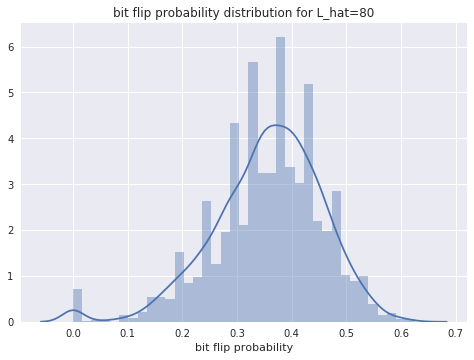

In [17]:
# L_hat=80
Z_pred1 = clf.predict(X_te)
err1 = util.hamming(Z_te, Z_pred1)
sns.distplot(err1)
plt.title('bit flip probability distribution for L_hat=80')
plt.xlabel('bit flip probability')

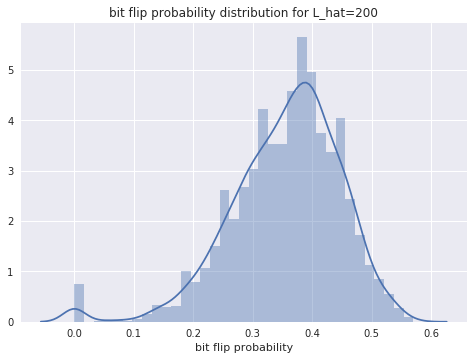

In [18]:
Z_pred2 = clf2.predict(X_te)
err2 = util.hamming(Z_te2, Z_pred2)
sns.distplot(err2)
plt.title('bit flip probability distribution for L_hat=200')
plt.xlabel('bit flip probability')

In [19]:
err1.mean()

0.35633045525902668

In [20]:
err2.mean()

0.35546310832025113

#### 3.2 Synthetic Error Correction Code

test by RandomForest.predict to generate z_pred and then ues kNN to find y.

We assume to have some method of recover Z_pred $\in\{0,1\}^{80}$ with $<30\%$ bit flip probability to the real Z_te. Then use this sythetic version of Z to predict Y.

In comparison, we have Z_tr2 $\in\{0,1\}^{200}$ and recover y from it directly.

Then we compare the 2 results to see if this "error correction" works in terms of precision@k

In [21]:
from util import Predictor

In [22]:
class Predictor_syn(Predictor):
    '''
    This is the predictor with sythetic "error correction"
    Replace the Z_pred who has <30% error with the real Z_te data
    
    Attribute:
        clf: randomforest classifier clf.predcit(X)==>Z_pred
        index: nn search indexer
        Y_tr: the training data of Y in order to help kNN search
        Z_te: real data in order to synthetic the "error correction"
        
    Method:
        predict_z: return the partially "corrected" version of v_pred
        predict: use predict_z and kNN to take a weighted version of Y
    '''
    def __init__(self, classifier, indexer, Y_tr, Z_te, threshold=0.3):
        super(Predictor_syn, self).__init__(classifier, indexer, Y_tr)
        self.Z_te = Z_te
        self.threshold = threshold
        
    def predict_z(self, X):
        '''
        Predict Z_pred using self.clf
        Replace Z_pred who has less than 0.3 error with the true Z_te
        '''
        def error(pred, real): #bit flip probability
            return (pred!=real).sum()/float(real.shape[0])
        Z_pred = self.clf.predict(X)
        Z_synt =  np.array([z2 if error(z1, z2)<self.threshold else z1 \
                         for z1, z2 in zip(Z_pred, self.Z_te)])
        #import pdb; pdb.set_trace()
        return Z_synt

In [23]:
# Initialize predictors
p1_origin = Predictor(clf, nn_index, Y_tr)
p1_synt = Predictor_syn(clf, nn_index, Y_tr, Z_te, threshold=0.35)
p2_origin = Predictor(clf2, nn_index2, Y_tr)

In [24]:
import util
Y_pred = p1_origin.predict(X_te)
for i in np.arange(1,6,2):
    print "p@{} for predictor {}:\t {}\n".format(i, 'p1_origin' ,util.precision_at_k(Y_te, Y_pred, i))

p@1 for predictor p1_origin:	 0.608163265306

p@3 for predictor p1_origin:	 0.564835164835

p@5 for predictor p1_origin:	 0.522762951334



In [25]:
Y_pred = p1_synt.predict(X_te)
for i in np.arange(1,6,2):
    print "p@{} for predictor {}:\t {}\n".format(i, 'p1_synt' ,util.precision_at_k(Y_te, Y_pred, i))

p@1 for predictor p1_synt:	 0.656200941915

p@3 for predictor p1_synt:	 0.619256933543

p@5 for predictor p1_synt:	 0.586436420722



In [26]:
Y_pred = p2_origin.predict(X_te)
for i in np.arange(1,6,2):
    print "p@{} for predictor {}:\t {}\n".format(i, 'p2_origin' ,util.precision_at_k(Y_te, Y_pred, i))

p@1 for predictor p2_origin:	 0.62103610675

p@3 for predictor p2_origin:	 0.580952380952

p@5 for predictor p2_origin:	 0.542857142857



#### 3.3 Simulate the "perfect error correctin" on different threshold

In the process, the encoding embeding space dimension $\hat L'$ is related to the correcting threshold we use.

let's assume the correcting threshold to be t, the redundent bit to be $C=\hat  L'-\hat L$, then we have:

\begin{align*}
    &\frac{C}{2}=t(\hat L+C)\\
    \Rightarrow& \hat L' = (1+\frac{2t}{1-2t})\hat L
\end{align*}

In [27]:
from util import precision_at_k
precision_L80_synt = []
precision_L_new = []
threshold_range = np.arange(0.3,0.5,0.05)
for threshold in threshold_range:
    # synthetic prediction on L_hat=80
    p_synt = Predictor_syn(clf, nn_index, Y_tr, Z_te, threshold)
    Y_synt = p_synt.predict(X_te)
    precision_L80_synt.append(precision_at_k(Y_te, Y_synt, 1))
    
    # prediction on L_hat_new
    L_hat_new = int((1+2*threshold/(1-2*threshold))*L_hat)
    Z_tr_new = util.map_2_z(Y_tr, L_hat_new)
    # classifier
    clf_new = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=1)
    clf_new.fit(X_tr, Z_tr_new)
    # knn index
    nn_index_new = faiss.index_factory(Z_tr_new.shape[1], "Flat", faiss.METRIC_L2)   # build the index
    nn_index_new.add(Z_tr_new.astype('float32'))
    p_new = Predictor(clf_new, nn_index_new, Y_tr)
    Y_pred_new = p_new.predict(X_te)
    precision_L_new.append(precision_at_k(Y_te, Y_pred_new, 1))
pk_origin = precision_at_k(Y_te, p1_origin.predict(X_te))

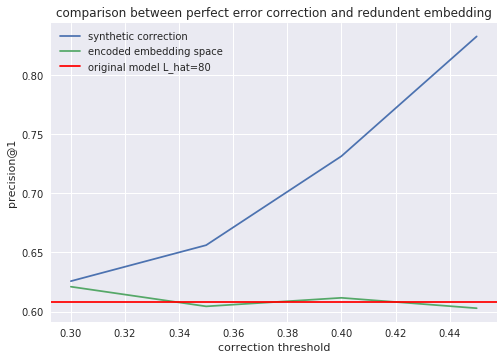

In [42]:
plt.plot(threshold_range, precision_L80_synt, label='synthetic correction')
plt.plot(threshold_range, precision_L_new, label='encoded embedding space')
plt.axhline(y=pk_origin, label='original model L_hat=80',color='r', linestyle='-')
plt.title('comparison between perfect error correction and redundent embedding')
plt.ylabel('precision@1')
plt.xlabel('correction threshold')
plt.legend()

In [31]:
L_hat_new = 500
Z_tr_new = util.map_2_z(Y_tr, L_hat_new)
# classifier
clf_new = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=1)
clf_new.fit(X_tr, Z_tr_new)
# knn index
nn_index_new = faiss.index_factory(Z_tr_new.shape[1], "Flat", faiss.METRIC_L2)   # build the index
nn_index_new.add(Z_tr_new.astype('float32'))
p_new = Predictor(clf_new, nn_index_new, Y_tr)
